#  TP : Data Centers, Green IT et Data Science
### Master 2 – Data / IA

---

## Objectifs du TP
- Manipuler un **dataset réel** lié aux infrastructures numériques.
- Explorer les **enjeux énergétiques et environnementaux** des data centers.
- Développer des compétences en **nettoyage, analyse et visualisation de données**.
- Relier l’analyse statistique aux **cadres réglementaires (UE, USA, Singapour, Australie)**.
- Appliquer des techniques de **Data Science (corrélations, modèles de régression)**.
- Mettre en œuvre un pipeline simple de **CI/CD** pour automatiser l’analyse.


##  Données
Fichier fourni : `Book1.csv` (extrait d’une base mondiale de data centers).

Variables principales :
- `Country` : pays
- `Continent` : continent
- `Number of data centres` : nombre total recensé
- `Gross Power (MW)` : puissance électrique installée
- `Renewable Energy Usage (%)` : part estimée d’énergie renouvelable
- Autres colonnes liées aux surfaces, capacités, données disponibles…


## Partie 1 — Préparation & Nettoyage des données
**Travail attendu :**
1. Charger le dataset avec `pandas`.
2. Vérifier le nombre de lignes/colonnes et explorer les 5 premières lignes.
3. Identifier et traiter les valeurs manquantes (par suppression ou imputation).
4. Supprimer les colonnes inutiles pour l’analyse.
5. Construire un **mini dictionnaire de données** avec 3 colonnes clés.

 **Question :** pourquoi un dictionnaire de données est-il indispensable dans un projet de gouvernance des données ?

In [19]:
# ÉTAPE 1 — Préparation & nettoyage
import re, os, numpy as np, pandas as pd
from IPython.display import display

# 1) Charger le fichier (prend le bon nom automatiquement)
fname = "Book1.csv" if os.path.exists("Book1.csv") else "Book1 (1).csv"
df = pd.read_csv(fname)

# 2) Garder UNIQUEMENT les colonnes utiles du sujet
must_have = ["country", "total_data_centers",
             "power_capacity_MW_total", "average_renewable_energy_usage_percent"]
missing = [c for c in must_have if c not in df.columns]
if missing:
    raise ValueError(f"Colonnes manquantes dans le CSV : {missing}\nColonnes trouvées : {list(df.columns)}")

df_clean = df[must_have].copy()

# 3) Nettoyage robuste
# 3a) total_data_centers -> entier (NaN -> 0)
df_clean["total_data_centers"] = pd.to_numeric(df_clean["total_data_centers"], errors="coerce").fillna(0).astype(int)

# 3b) power_capacity_MW_total -> float (enlève ~ + , espace ; 'Unknown' -> NaN ; multiple points géré)
def clean_power(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip().lower()
    if s in {"unknown", "na", "n/a", "-", "--"}:
        return np.nan
    s = re.sub(r"[~+, ]", "", s)              # retire ~ + , espaces
    s = re.sub(r"[^\d.]", "", s)              # garde chiffres et points
    s = re.sub(r"\.(?=.*\.)", "", s)          # supprime tous les points sauf le dernier
    if s in {"", "."}:
        return np.nan
    try:
        return float(s)
    except:
        return np.nan

df_clean["power_capacity_num"] = df_clean["power_capacity_MW_total"].apply(clean_power)

# 3c) average_renewable_energy_usage_percent -> float en % (0..100)
def clean_percent(val):
    if pd.isna(val):
        return np.nan
    s = str(val).replace("+", "").strip()
    if "%" in s:                               # cas "40%" ou "~27%"
        s = re.sub(r"[^0-9.]", "", s) or np.nan
        return float(s) if s is not np.nan else np.nan
    # cas numérique / fraction : 0.25 -> 25 ; 25 -> 25 ; 1.2 -> 1.2 (>=1 => déjà en %)
    try:
        x = float(s)
        return x*100 if x <= 1 else x
    except:
        return np.nan

df_clean["renewable_num"] = df_clean["average_renewable_energy_usage_percent"].apply(clean_percent).clip(0, 100)

# 4) Aperçu & contrôles
print("Shape (lignes, colonnes):", df_clean.shape)
print("\nValeurs manquantes par colonne :")
display(df_clean[["country","total_data_centers","power_capacity_num","renewable_num"]].isna().sum())
print("\nAperçu :")
display(df_clean.head())

# (Optionnel) mini dictionnaire imprimé
print("\nDictionnaire de données (colonnes utilisées) :")
print("- country : Nom du pays.")
print("- total_data_centers : Nombre total de data centers recensés (entier).")
print("- power_capacity_num : Puissance électrique installée, en MW (numérique nettoyé).")
print("- renewable_num : % d’énergie renouvelable (0–100, nettoyé).")


Shape (lignes, colonnes): (191, 6)

Valeurs manquantes par colonne :


country                0
total_data_centers     0
power_capacity_num    26
renewable_num         44
dtype: int64


Aperçu :


,country,total_data_centers,power_capacity_MW_total,average_renewable_energy_usage_percent,power_capacity_num,renewable_num
0,United States,5426,"~12,000+",~27%,12000.0,27.0
1,Germany,529,"~2,000+",40%+,2000.0,40.0
2,United Kingdom,523,"~1,000+",0.45,1000.0,45.0
3,China,449,"~8,000+",0.25,8000.0,25.0
4,France,322,~700,40%+,700.0,40.0



Dictionnaire de données (colonnes utilisées) :
- country : Nom du pays.
- total_data_centers : Nombre total de data centers recensés (entier).
- power_capacity_num : Puissance électrique installée, en MW (numérique nettoyé).
- renewable_num : % d’énergie renouvelable (0–100, nettoyé).


## Partie 2 — Exploration et Visualisation
**Travail attendu :**
1. Identifier les **10 pays** avec le plus grand nombre de data centers.
   - Afficher sous forme de tableau.
   - Tracer un graphique en barres.
2. Représenter la distribution de la **puissance installée (MW)**.
3. Tracer un **scatter plot** entre `Gross Power (MW)` et `% renouvelable`.

 **Question :** commentez la relation observée. Est-ce que la puissance d’un data center permet de prédire sa durabilité ?

Top 10 pays par nombre de data centers :


,country,total_data_centers
182,United States,5426
64,Germany,529
181,United Kingdom,523
35,China,449
30,Canada,336
60,France,322
8,Australia,314
122,Netherlands,298
141,Russia,251
84,Japan,222


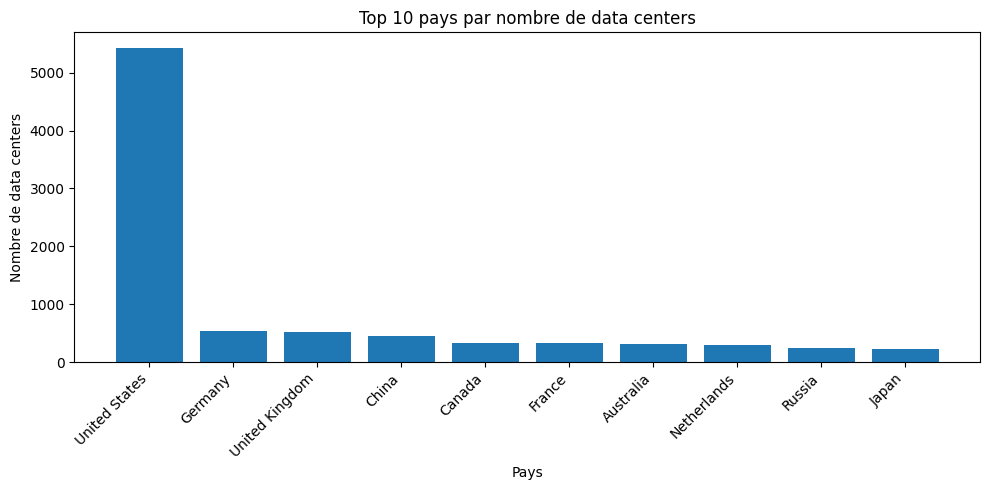

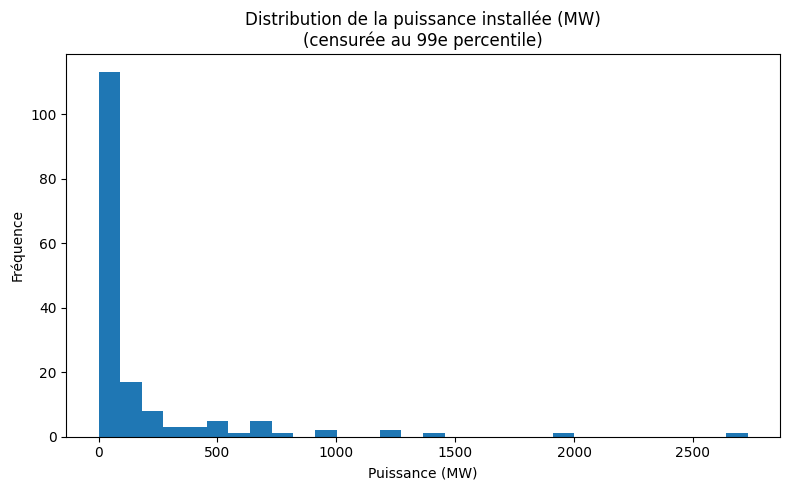

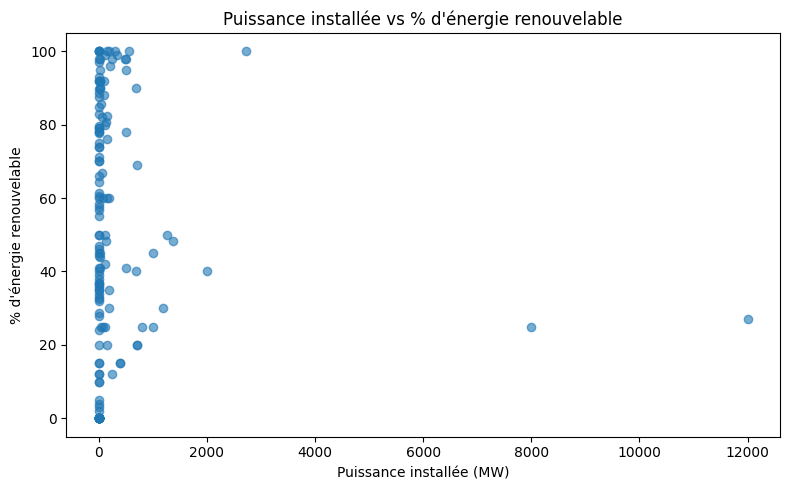

In [20]:
# ÉTAPE 2 — Exploration & visualisation
import matplotlib.pyplot as plt

# 1) Top 10 pays par nombre de data centers
top10 = (df_clean.groupby("country", as_index=False)["total_data_centers"]
                 .sum()
                 .sort_values("total_data_centers", ascending=False)
                 .head(10))

print("Top 10 pays par nombre de data centers :")
display(top10)

plt.figure(figsize=(10,5))
plt.bar(top10["country"], top10["total_data_centers"])
plt.title("Top 10 pays par nombre de data centers")
plt.xlabel("Pays"); plt.ylabel("Nombre de data centers")
plt.xticks(rotation=45, ha="right"); plt.tight_layout()
plt.show()

# 2) Distribution de la puissance installée (MW)
p = df_clean["power_capacity_num"].dropna()
if len(p) > 0:
    cap99 = p.quantile(0.99)            # on censure le 1% le plus élevé pour la lisibilité
    p_clip = p[p <= cap99]
    plt.figure(figsize=(8,5))
    plt.hist(p_clip, bins=30)
    plt.title("Distribution de la puissance installée (MW)\n(censurée au 99e percentile)")
    plt.xlabel("Puissance (MW)"); plt.ylabel("Fréquence")
    plt.tight_layout()
    plt.show()
else:
    print("Aucune valeur numérique valide dans power_capacity_num pour tracer l'histogramme.")

# 3) Scatter : Puissance (MW) vs % d’énergie renouvelable
scatter_df = df_clean[["power_capacity_num","renewable_num"]].dropna()
if len(scatter_df) > 0:
    plt.figure(figsize=(8,5))
    plt.scatter(scatter_df["power_capacity_num"], scatter_df["renewable_num"], alpha=0.6)
    plt.title("Puissance installée vs % d'énergie renouvelable")
    plt.xlabel("Puissance installée (MW)"); plt.ylabel("% d'énergie renouvelable")
    plt.tight_layout()
    plt.show()
else:
    print("Données insuffisantes pour le scatter (besoin de power_capacity_num et renewable_num non nuls).")


## Partie 3 — Comparaison intercontinentale
**Travail attendu :**
1. Agréger par **continent** le `% d’énergie renouvelable`.
2. Comparer les continents dans un **bar chart**.
3. Focus sur l’Europe vs Amérique du Nord :
   - Calculer la moyenne et l’écart-type du `% renouvelable`.
   - Discuter les différences en lien avec les lois (EED en Europe vs ENERGY STAR aux USA).

 **Question :** que montrent ces écarts sur l’efficacité des lois européennes par rapport aux approches volontaires américaines ?

,continent,renewables_mean_pct
3,North America,68.333333
6,South America,68.112500
1,Asia,65.236000
2,Europe,65.151613
4,Oceania,63.000000
0,Africa,53.450000
5,Other/Unknown,38.003125


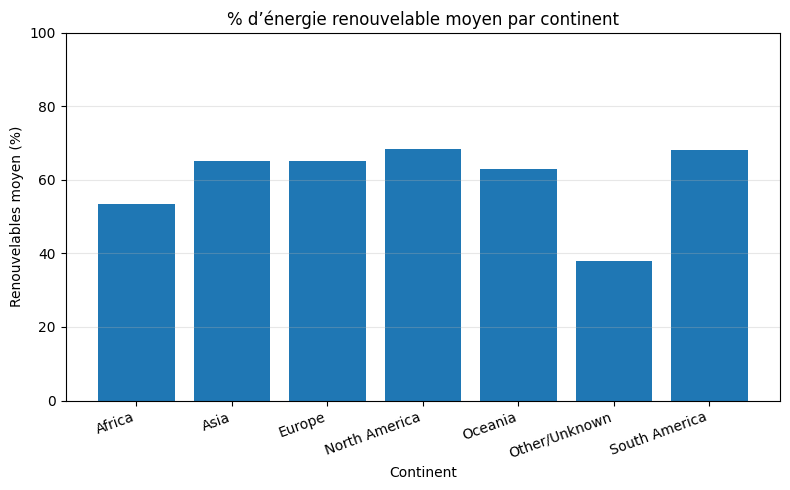

Europe  -> n=31, mean=65.15%, std=31.70
N. Amer -> n=3, mean=68.33%, std=37.45


,continent,renewables_mean_pct
3,North America,68.333333
6,South America,68.112500
1,Asia,65.236000
2,Europe,65.151613
4,Oceania,63.000000
0,Africa,53.450000
5,Other/Unknown,38.003125


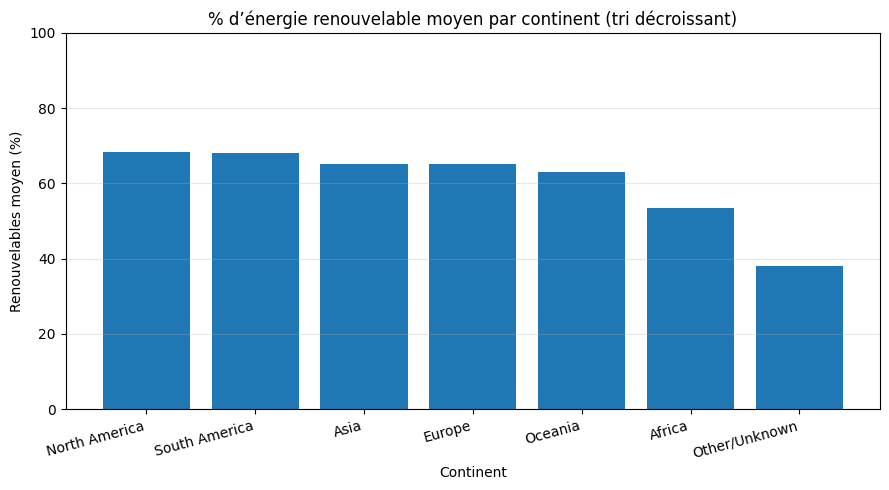

Europe  -> n=31, mean=65.15%, std=31.70
N. Amer -> n=3, mean=68.33%, std=37.45


In [25]:
# ÉTAPE 3 — Comparaison intercontinentale
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# On part de df_clean avec 'country', 'renewable_num' (0..100) déjà nettoyé à l'étape 1

# 0) Si 'continent' n'existe pas, on le crée par mapping des pays
if "continent" not in df_clean.columns:
    def map_continent(country):
        c = str(country).strip().lower()

        na = {
            "united states","usa","us","canada","mexico"
        }
        sa = {
            "brazil","argentina","chile","colombia","peru","uruguay","paraguay",
            "bolivia","ecuador","venezuela","guyana","suriname"
        }
        eu = {
            "united kingdom","uk","great britain","england","scotland","wales","northern ireland",
            "ireland","france","germany","spain","portugal","italy","netherlands","belgium",
            "switzerland","austria","poland","czech republic","czechia","slovakia","hungary",
            "romania","bulgaria","greece","croatia","slovenia","serbia","bosnia","montenegro",
            "north macedonia","albania","lithuania","latvia","estonia","finland","sweden","norway",
            "denmark","iceland","luxembourg","malta","cyprus","ukraine","moldova","belarus",
            "turkey","russia"
        }
        asia = {
            "china","japan","south korea","korea, republic of","republic of korea","india",
            "singapore","hong kong","taiwan","thailand","vietnam","indonesia","malaysia",
            "philippines","pakistan","bangladesh","sri lanka","nepal","cambodia","laos","myanmar",
            "united arab emirates","uae","saudi arabia","qatar","kuwait","bahrain","oman",
            "israel","jordan","lebanon","iran","iraq","kazakhstan","uzbekistan"
        }
        africa = {
            "south africa","egypt","morocco","tunisia","algeria","nigeria","ghana","kenya",
            "ethiopia","tanzania","uganda","senegal","cote d'ivoire","côte d’ivoire","ivory coast",
            "angola","botswana","namibia","rwanda"
        }
        oceania = {"australia","new zealand"}

        if c in na: return "North America"
        if c in sa: return "South America"
        if c in eu: return "Europe"
        if c in asia: return "Asia"
        if c in africa: return "Africa"
        if c in oceania: return "Oceania"
        return "Other/Unknown"

    df_clean["continent"] = df_clean["country"].apply(map_continent)

# 1) Agréger par continent le % d’énergie renouvelable
cont_agg = (df_clean[["continent","renewable_num"]]
            .dropna()
            .groupby("continent", as_index=False)["renewable_num"]
            .mean()
            .rename(columns={"renewable_num": "renewables_mean_pct"}))

display(cont_agg.sort_values("renewables_mean_pct", ascending=False))

# 2) Bar chart par continent
plt.figure(figsize=(8,5))
plt.bar(cont_agg["continent"], cont_agg["renewables_mean_pct"])
plt.title("% d’énergie renouvelable moyen par continent")
plt.xlabel("Continent"); plt.ylabel("Renouvelables moyen (%)")
plt.ylim(0, 100)
plt.xticks(rotation=20, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Focus Europe vs Amérique du Nord : moyenne & écart-type
def stats_region(df_, region_name):
    s = df_.loc[df_["continent"].str.lower() == region_name.lower(), "renewable_num"].dropna()
    if s.empty:
        return {"n": 0, "mean": np.nan, "std": np.nan}
    return {"n": int(s.shape[0]), "mean": float(s.mean()), "std": float(s.std(ddof=1))}

eu_stats = stats_region(df_clean, "Europe")
na_stats = stats_region(df_clean, "North America")

print("Europe  -> n={n}, mean={mean:.2f}%, std={std:.2f}".format(**eu_stats))
print("N. Amer -> n={n}, mean={mean:.2f}%, std={std:.2f}".format(**na_stats))

# 1) Agréger par continent le % d’énergie renouvelable, puis TRIER décroissant
cont_agg = (df_clean[["continent","renewable_num"]]
            .dropna()
            .groupby("continent", as_index=False)["renewable_num"]
            .mean()
            .rename(columns={"renewable_num": "renewables_mean_pct"})
            .sort_values("renewables_mean_pct", ascending=False))

display(cont_agg)

# 2) Bar chart trié (du plus grand au plus petit)
plt.figure(figsize=(9,5))
plt.bar(cont_agg["continent"], cont_agg["renewables_mean_pct"])
plt.title("% d’énergie renouvelable moyen par continent (tri décroissant)")
plt.xlabel("Continent"); plt.ylabel("Renouvelables moyen (%)")
plt.ylim(0, 100)
plt.xticks(rotation=15, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Focus Europe vs Amérique du Nord (stats)
def stats_region(df_, region_name):
    s = df_.loc[df_["continent"].str.lower() == region_name.lower(), "renewable_num"].dropna()
    if s.empty:
        return {"n": 0, "mean": np.nan, "std": np.nan}
    return {"n": int(s.shape[0]), "mean": float(s.mean()), "std": float(s.std(ddof=1))}

eu_stats = stats_region(df_clean, "Europe")
na_stats = stats_region(df_clean, "North America")

print("Europe  -> n={n}, mean={mean:.2f}%, std={std:.2f}".format(**eu_stats))
print("N. Amer -> n={n}, mean={mean:.2f}%, std={std:.2f}".format(**na_stats))



## Partie 4 — Data Science
**Travail attendu :**
1. Calculer les **corrélations** entre variables (`Gross Power`, `% renouvelable`, `Number of data centres`).
2. Construire un **modèle de régression linéaire** simple :
   - `Y = % renouvelable`
   - `X = puissance installée (MW)`
3. Évaluer le modèle avec **R²** et **RMSE**.
4. Tester un **modèle multiple** (ajouter `Number of data centres`).

 **Question :** expliquez pourquoi un R² faible est **aussi une information précieuse** en gouvernance énergétique.

In [ ]:
!pip install scikit-learn

In [27]:
# ÉTAPE 4 — Data Science (corrélations + régressions)
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd

# 0) Préparation des données numériques (on enlève les NaN)
data = df_clean[["renewable_num", "power_capacity_num", "total_data_centers"]].dropna().copy()

y  = data["renewable_num"].to_numpy(dtype=float)                         # Y = % renouvelable
X1 = data[["power_capacity_num"]].to_numpy(dtype=float)                  # X simple = puissance (MW)
X2 = data[["power_capacity_num", "total_data_centers"]].to_numpy(dtype=float)  # X multiple

# Petite fonction RMSE compatible toutes versions de sklearn
def rmse(y_true, y_pred):
    try:
        # nouvelles versions (>=0.22)
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        # anciennes versions
        return np.sqrt(mean_squared_error(y_true, y_pred))

# 1) Corrélations
num_cols = ["power_capacity_num", "renewable_num", "total_data_centers"]
corr = data[num_cols].corr(numeric_only=True)
print("Corrélations :")
display(corr)

# 2) Régression linéaire simple : Y = %renouvelable, X = puissance (MW)
model1 = LinearRegression().fit(X1, y)
pred1  = model1.predict(X1)
r2_1   = r2_score(y, pred1)
rmse_1 = rmse(y, pred1)

print(f"\nRégression simple : R² = {r2_1:.4f},  RMSE = {rmse_1:.2f}")
print(f"  Coef(MW -> %renouvelable) = {model1.coef_[0]:.6f},  Intercept = {model1.intercept_:.3f}")

# 3) Régression linéaire multiple : X = [puissance (MW), #DC]
model2 = LinearRegression().fit(X2, y)
pred2  = model2.predict(X2)
r2_2   = r2_score(y, pred2)
rmse_2 = rmse(y, pred2)

print(f"\nRégression multiple : R² = {r2_2:.4f},  RMSE = {rmse_2:.2f}")
print("  Coefs = {MW: %.6f, #DC: %.6f}, Intercept = %.3f" %
      (model2.coef_[0], model2.coef_[1], model2.intercept_))


Corrélations :


,power_capacity_num,renewable_num,total_data_centers
power_capacity_num,1.000000,-0.061779,0.849935
renewable_num,-0.061779,1.000000,-0.069250
total_data_centers,0.849935,-0.069250,1.000000



Régression simple : R² = 0.0038,  RMSE = 33.14
  Coef(MW -> %renouvelable) = -0.001674,  Intercept = 52.686

Régression multiple : R² = 0.0048,  RMSE = 33.12
  Coefs = {MW: -0.000285, #DC: -0.004411}, Intercept = 52.607


## Partie 5 — CI/CD
**Travail attendu :**
1. Créer un fichier `requirements.txt` listant vos dépendances (pandas, matplotlib, scikit-learn, pytest…).
2. Écrire un petit fichier de test `test_sample.py` avec au moins 2 assertions.
3. Créer un workflow GitHub Actions `.github/workflows/python-ci.yml` qui :
   - installe les dépendances,
   - exécute `pytest`,
   - lance le notebook pour vérifier qu’il s’exécute sans erreur.

 **Question :** en quoi l’automatisation CI/CD est-elle une bonne pratique de **Green IT** ?

In [12]:
# Votre code ici
# === Crée requirements.txt, test_sample.py et le workflow GitHub Actions ===
from pathlib import Path

# 1) requirements.txt
Path("requirements.txt").write_text("""\
pandas>=2.0
numpy>=1.25
matplotlib>=3.7
scikit-learn>=1.3
pytest>=7.4
jupyter>=1.0
papermill>=2.5
""", encoding="utf-8")

# 2) test_sample.py (au moins 2 assertions)
Path("test_sample.py").write_text("""\
def add(a, b):
    return a + b

def test_add():
    assert add(2, 3) == 5

def test_list_math():
    xs = [1, 2, 3]
    assert len(xs) == 3
    assert sum(xs) == 6
""", encoding="utf-8")

# 3) Workflow GitHub Actions
Path(".github/workflows").mkdir(parents=True, exist_ok=True)
Path(".github/workflows/python-ci.yml").write_text("""\
name: Python CI

on:
  push:
  pull_request:

jobs:
  build:
    runs-on: ubuntu-latest
    steps:
      - name: Checkout
        uses: actions/checkout@v4

      - name: Set up Python
        uses: actions/setup-python@v5
        with:
          python-version: '3.11'

      - name: Install dependencies
        run: |
          python -m pip install --upgrade pip
          pip install -r requirements.txt

      - name: Run tests
        run: |
          pytest -q

      - name: Execute notebook with papermill
        run: |
          # Exécute le notebook et échoue si une cellule plante
          papermill TP_student.ipynb TP_student_out.ipynb -k python3
""", encoding="utf-8")

print("✅ Fichiers créés : requirements.txt, test_sample.py, .github/workflows/python-ci.yml")


✅ Fichiers créés : requirements.txt, test_sample.py, .github/workflows/python-ci.yml


##  Livrables attendus
- Un notebook `TP_Etudiant.ipynb` complété.
- Un mini dictionnaire de données en Markdown.
- Des visualisations (bar chart, scatter plot, comparatif continental).
- Une courte discussion (Europe vs USA).
- `requirements.txt`, `test_sample.py`, et le workflow CI/CD.

In [13]:
!pip install -r requirements.txt
!pytest -q
!papermill TP_student.ipynb TP_student_out.ipynb -k python3



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
..                                                                       [100%]
2 passed in 0.05s
Input Notebook:  TP_student.ipynb
Output Notebook: TP_student_out.ipynb
Executing notebook with kernel: python3                | 0/16 [00:00<?, ?cell/s]
Executing: 100%|██████████████████████████████| 16/16 [00:06<00:00,  2.38cell/s]


In [14]:
import os
print(os.listdir(".github/workflows"))


['python-ci.yml']
